In [1]:
import os,sys, operator
import shutil, gzip, math
import pickle
import numpy as np                                       # fast vectors and matrices
from glob import glob
from time import time
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch import tensor
from torch import nn
import torch.nn.functional as F

from pathlib import Path
from IPython.core.debugger import set_trace
from collections import Counter

%matplotlib inline

## Data Loader

In [3]:
train_feat_path="processed_dataset\\train\\feat\\"
train_label_path="processed_dataset\\train\\label\\"
test_feat_path="processed_dataset\\test\\feat\\"
test_label_path="processed_dataset\\test\\label\\"

train_name=os.listdir(train_feat_path)
test_name=os.listdir(test_feat_path)

class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_feat_path , label_path=train_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_feat_path , label_path=test_label_path , transform=None, target_transform=None):
        self.img_labels = os.listdir(train_feat_path)
        self.feat_path = feat_path 
        self.label_path = label_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        data = (torch.from_numpy(np.load(self.feat_path +self.img_labels[idx])))
        label = (torch.from_numpy(np.load(self.label_path +self.img_labels[idx])))
        print(self.feat_path +self.img_labels[idx])
        return data, label
    
    def demo() :
        for indices in train :
            yield collate_fn(train_dataset[i] for i in indices)


In [4]:
train_dataset=CustomTrainDataset()
test_dataset=CustomTrainDataset()

## model

In [47]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out, kar):
        super().__init__()
        #self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)] 
        self.layers = [nn.Conv1d(n_in, nh, kar), nn.Conv1d(nh, nh,  kar), nn.Linear(nh, n_out)] 
        print(self.layers)       
    def __call__(self, x):
        for k in self.layers:
            x = k(x)
        return x

def normalize(x, m, s): 
    return (x-m)/s

In [6]:
from sklearn.metrics import mean_squared_error
from torch import nn
loss = nn.MSELoss()

In [48]:
def M_accuracy(yhat, y):
    predictions = yhat.detach().numpy()
    true_values = y.detach().numpy()
    predictions = (predictions >=0.5) 
    correct = ((predictions >=0.5) == true_values)
    
    ct, CT=0,0
    for i in range(len(true_values)) :
        if true_values[i]==1 :
            CT+=1
            if(predictions[i]==1) :
                ct+=1

    if CT==0 : return 1
    return ct/CT

def M_loss_func(yhat,y):
    predictions = yhat
    true_values = y
    
    return loss(true_values, predictions)


learing rate : .001/3/3/3  -> (tensor(-0.8370, grad_fn=<MeanBackward0>), 0.7207684659090909)
learing rate : .001  -> (tensor(-5.2699e+11, grad_fn=<MeanBackward0>), 0.9682017045454545)
note miss : 32

เราต้องถ่วง weight โดยให้ค่าจากการตอบ 1 ถูก ดีกว่าค่าจากการตอบ 0 ถูก
MSE in losss function : แต่เหวี่ยงๆ (tensor(0.0555, grad_fn=<MseLossBackward0>), 0.9431818181818182)
MSE + acc in 1 : (tensor(0.0212, grad_fn=<MseLossBackward0>), 0.0) // acc มันเหวี่ยงๆขึ้นลง


In [8]:
batch=32
lr = 0.02#.001/3/3/3 
nh = 88
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

In [9]:
d,l =next(iter(train))
c = l.max()
k, m=d[1].size()

In [49]:
#model = Model(m, nh, l.size(dim=2)) #model = Model(120, nh, l.size(dim=2))
model = Model(120, 128, 88, k=1)

TypeError: __init__() got an unexpected keyword argument 'k'

In [26]:
x,y =next(iter(train))

In [44]:
x[0].size()

torch.Size([1500, 120])

In [50]:
yhatb = model(x[0])

RuntimeError: Given groups=1, weight of size [128, 120, 1], expected input[1, 1500, 120] to have 120 channels, but got 1500 channels instead

## loop

In [14]:
batch = 16
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)

losses, metrics = [], []
epoch = train.__len__()
lr=.001/3/3

In [15]:
from torch.utils.data import DataLoader
train = DataLoader(train_dataset, batch_size=batch, shuffle=True)
epoch = train.__len__()

In [16]:
def get_epoch(k):
    print("epoch","\t loss \tacc")
    for i in range(0,k) :
        train_epoch()
        print(i,"\t",losses[-1],"\t",metrics[-1])

def train_epoch():
    x,y =next(iter(train))
    for i in range(batch) :
        for j in range(1500) :
            xb=x[i][j]
            yb=y[i][j]
            if not( 1 in yb) :
                continue
            yhatb = model(xb)
            loss = M_loss_func(yhatb, yb)
            acc = M_accuracy(yhatb, yb)    
            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        #l.weight.step()
                        l.bias.grad.zero_()
                        #l.bias.step()
            losses.append(loss); metrics.append(acc)

In [ ]:
losses, metrics = [], []
get_epoch(10)

In [14]:
temp_l, temp_acc=[],[]
for k in losses :
    temp_l.append(k.detach())
    #temp_l.append(k)

for k in metrics :
    #temp_acc.append(k.detach())
    temp_acc.append(k)

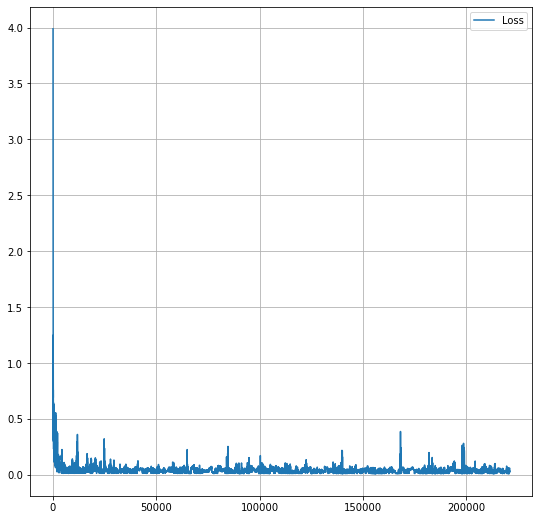

In [15]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_l, label="Loss")
ax.legend(loc='upper right')

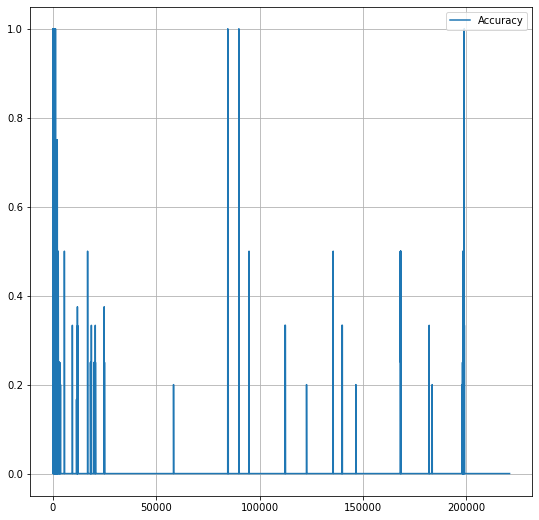

In [16]:
x = torch.arange(len(losses)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, temp_acc, label="Accuracy")
ax.legend(loc='upper right')

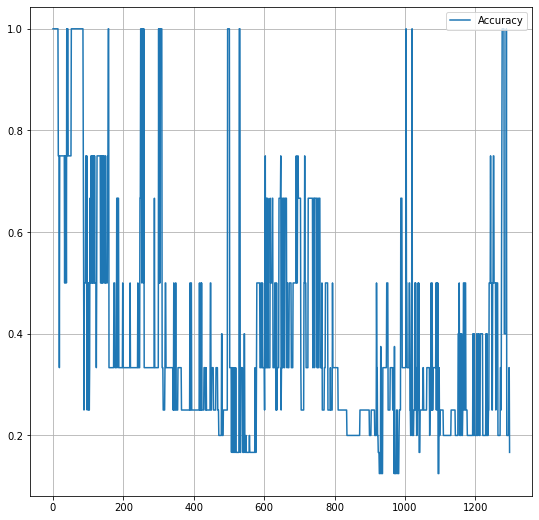

In [17]:
y1=[item  for item in temp_acc if (item>0)]

x = torch.arange(len(y1)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, y1, label="Accuracy")
ax.legend(loc='upper right')

In [20]:
#losses[-1], metrics[-1]
losses[-1], sum(y1)/len(y1)

(tensor(0.0428, grad_fn=<MseLossBackward0>), 0.3678758565094715)

## TEST

In [21]:
test = DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [22]:
def get_test_epoch(k):
    for i in range(0,k) :
        test_epoch()

def test_epoch():
    x,y =next(iter(test))
    for i in range(batch) :
        for j in range(1500) :
            xb=x[i][j]
            yb=y[i][j]
            yhatb = model(xb)
            acc = M_accuracy(yhatb, yb)    
            metrics_test.append(acc)

In [23]:
losses_test=[]
metrics_test=[]
get_test_epoch(5)

In [31]:
sum(metrics_test)/len(metrics_test)

0.06989098544973546

In [33]:
test_l, test_acc=[],[]
for k in losses :
    test_l.append(k.detach())

for k in metrics :
    test_acc.append(k)

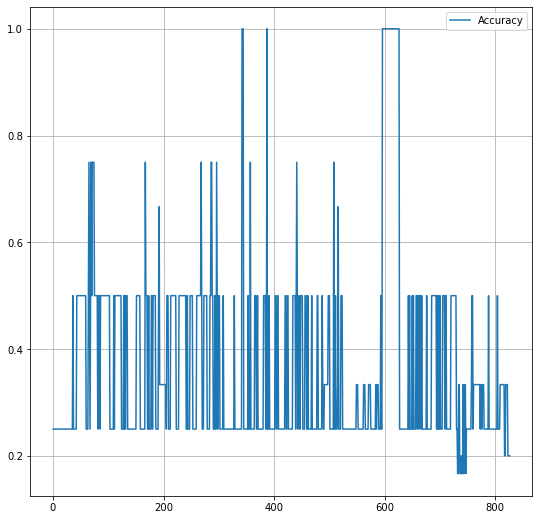

In [35]:
y1=[item  for item in test_acc if (item>0)]

x = torch.arange(len(y1)).numpy()
fig,ax = plt.subplots(figsize=(9, 9))
ax.grid(True)
ax.plot(x, y1, label="Accuracy")
ax.legend(loc='upper right')

In [32]:
accuracy=M_accuracy(xy[0][0],y[0][0])
xy=(xy>=0.5).float()
correct = ((xy >=0.5) == y)

count = 4224000
count_t = (correct.float() == 1).sum()
count_f = (correct.float() == 0).sum()

accuracy , count_t/count, count_f/count

In [ ]:
xy[0][0], y[0][0]

In [35]:
tx=xy.detach().numpy()
ty=y.detach().numpy()

In [36]:
#วัดตัวที่ทายผิดใน epoch test

N=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct=0;
        for k in range(88) : 
            if(tx[i][j][k] != ty[i][j][k]) :
                ct+=1
        N=np.append(N,ct)

print(N.mean())


2.812666666666667


In [39]:
#วัดตัวที่ทาย 1 เป็น 0 ใน epoch test
K=np.array([])
for i in range(batch) :
    for j in range(1500) :
        ct,CT =0,0;
        for k in range(88) : 
            if ty[i][j][k]==1 :
                CT+=1
                if(tx[i][j][k]==0) :
                    ct+=1
        if(CT==0) :
            if(ct==0) : K=np.append(K,0)
            else : K=np.append(K,ct)
        else : K=np.append(K,ct/CT)

print(K.mean())

0.927875
